# Notebook to demonstrate Zero shot and Few shot Learning

In [52]:
import pandas as pd 
import numpy as np
from langchain_groq.chat_models import ChatGroq


# Create list for easy access of activities
ACTIVITIES = {1: 'WALKING',2: 'WALKING_UPSTAIRS',3: 'WALKING_DOWNSTAIRS',4: 'SITTING',5: 'STANDING',6: 'LAYING',}

In [53]:
# Groq API and Models 
Groq_Token = "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"  # Do not share this key with anyone

groq_models = {"llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

**NOTE : DO NOT SHARE THE API KEY WITH ANYONE. DO NOT COMMIT THE API KEY TO GITHUB.**

Always do a sanity check before committing the code to github. If the key is found in the code, you will be penalized with a 0.5 marks deduction.

#DATA EXTRACTION

Shape of X_train_acc: (7352, 384)
Shape of X_test_acc: (2947, 384)
Shape of y_train_acc: (7352, 1)
Shape of y_test_acc: (2947, 1)
Shape of X_train_tsfel: (7352, 120)
Shape of X_test_tsfel: (2947, 120)
Accuracy: 0.6905
Precision: 0.7010
Recall: 0.6905


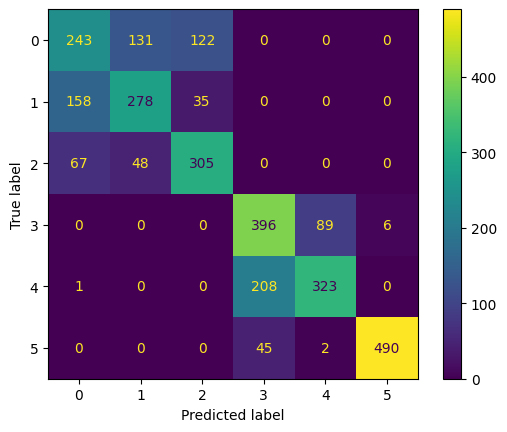

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import warnings

# Suppressing all FutureWarnings and UserWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load train and test accelerometer data
train_acc_x = pd.read_csv("UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt", delim_whitespace=True, header=None)
train_acc_y = pd.read_csv("UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt", delim_whitespace=True, header=None)
train_acc_z = pd.read_csv("UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt", delim_whitespace=True, header=None)

test_acc_x = pd.read_csv("UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt", delim_whitespace=True, header=None)
test_acc_y = pd.read_csv("UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt", delim_whitespace=True, header=None)
test_acc_z = pd.read_csv("UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt", delim_whitespace=True, header=None)

# Concatenating the three accelerometer axes
X_train_acc = np.hstack((train_acc_x.values, train_acc_y.values, train_acc_z.values))
X_test_acc = np.hstack((test_acc_x.values, test_acc_y.values, test_acc_z.values))

print(f"Shape of X_train_acc: {X_train_acc.shape}")
print(f"Shape of X_test_acc: {X_test_acc.shape}")

# Load train and test labels
y_train_acc = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['Activity'])
y_test_acc = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['Activity'])

print(f"Shape of y_train_acc: {y_train_acc.shape}")
print(f"Shape of y_test_acc: {y_test_acc.shape}")

# Featurization function with TSFEL
def extract_features(X, max_readings=500):
    """Extract statistical features from time series data using TSFEL."""
    # Use TSFEL's statistical feature configuration
    cfg = tsfel.get_features_by_domain("statistical")
    tsfel_features = []

    for sample in X:
        # Limit to max_readings if necessary
        sample_limited = sample[:max_readings]
        
        # Reshape sample to (1, time_steps, 3) format expected by TSFEL
        sample_reshaped = sample_limited.reshape(1, -1, 3)
        
        # Extract features
        features = tsfel.time_series_features_extractor(cfg, sample_reshaped[0], verbose=0)
        
        # Flatten features and append to the list
        tsfel_features.append(features.values.flatten())

    # Convert to DataFrame
    return pd.DataFrame(tsfel_features)

# Extract features for both train and test datasets
X_train_tsfel = extract_features(X_train_acc)
X_test_tsfel = extract_features(X_test_acc)

print(f"Shape of X_train_tsfel: {X_train_tsfel.shape}")
print(f"Shape of X_test_tsfel: {X_test_tsfel.shape}")

# Train a Decision Tree classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_tsfel, y_train_acc)

# Predict and evaluate
y_pred = classifier.predict(X_test_tsfel)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_acc, y_pred)
precision = precision_score(y_test_acc, y_pred, average='weighted')
recall = recall_score(y_test_acc, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_acc, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.show()


# TSEFL Featurised Data

In [55]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd

# Define paths for raw accelerometer data
base_data_path = "./UCI HAR Dataset/Train/Inertial Signals/"
test_data_path = "./UCI HAR Dataset/Test/Inertial Signals/"

# Load raw train accelerometer data
train_acc_x_raw = pd.read_csv(os.path.join(base_data_path, "total_acc_x_train.txt"), delim_whitespace=True, header=None)
train_acc_y_raw = pd.read_csv(os.path.join(base_data_path, "total_acc_y_train.txt"), delim_whitespace=True, header=None)
train_acc_z_raw = pd.read_csv(os.path.join(base_data_path, "total_acc_z_train.txt"), delim_whitespace=True, header=None)

# Load raw test accelerometer data
test_acc_x_raw = pd.read_csv(os.path.join(test_data_path, "total_acc_x_test.txt"), delim_whitespace=True, header=None)
test_acc_y_raw = pd.read_csv(os.path.join(test_data_path, "total_acc_y_test.txt"), delim_whitespace=True, header=None)
test_acc_z_raw = pd.read_csv(os.path.join(test_data_path, "total_acc_z_test.txt"), delim_whitespace=True, header=None)

# Concatenate raw accelerometer data to create full dataset
X_train_raw = np.concatenate((train_acc_x_raw, train_acc_y_raw, train_acc_z_raw), axis=1)
X_test_raw = np.concatenate((test_acc_x_raw, test_acc_y_raw, test_acc_z_raw), axis=1)

print("Shape of X_train_raw:", X_train_raw.shape)
print("Shape of X_test_raw:", X_test_raw.shape)

# Load activity labels for train and test sets
y_train_labels = pd.read_csv(os.path.join("UCI HAR Dataset/train", "y_train.txt"), sep='\s+', header=None, names=['Activity'])
y_test_labels = pd.read_csv(os.path.join("UCI HAR Dataset/test", "y_test.txt"), sep='\s+', header=None, names=['Activity'])

print("Shape of y_train_labels:", y_train_labels.shape)
print("Shape of y_test_labels:", y_test_labels.shape)

# Assuming TSFEL processing is done earlier (not shown here)
# Here we use the raw data as placeholders for processed feature data
# Replace these with actual TSFEL-processed data
X_train_features = X_train_raw  # This should be your TSFEL processed data
X_test_features = X_test_raw    # This should be your TSFEL processed data

# Initialize PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)

# Initialize StandardScaler to standardize the data before PCA
scaler = StandardScaler()

# Standardize the training and test feature data
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Apply PCA to the standardized training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Apply the same PCA transformation to the test data
X_test_pca = pca.transform(X_test_scaled)

# Verify the shape of the PCA-transformed training data
print("Shape of X_train_pca:", X_train_pca.shape)

# Compute the mean PCA features for each activity in the training set
# This helps in creating representative mean vectors for each activity
activity_1_train_mean = X_train_pca[y_train_labels['Activity'] == 1].mean(axis=0)
activity_2_train_mean = X_train_pca[y_train_labels['Activity'] == 2].mean(axis=0)
activity_3_train_mean = X_train_pca[y_train_labels['Activity'] == 3].mean(axis=0)
activity_4_train_mean = X_train_pca[y_train_labels['Activity'] == 4].mean(axis=0)
activity_5_train_mean = X_train_pca[y_train_labels['Activity'] == 5].mean(axis=0)
activity_6_train_mean = X_train_pca[y_train_labels['Activity'] == 6].mean(axis=0)

# Organize PCA-transformed test data by activity labels
activity_1_test_data = X_test_pca[y_test_labels['Activity'] == 1]
activity_2_test_data = X_test_pca[y_test_labels['Activity'] == 2]
activity_3_test_data = X_test_pca[y_test_labels['Activity'] == 3]
activity_4_test_data = X_test_pca[y_test_labels['Activity'] == 4]
activity_5_test_data = X_test_pca[y_test_labels['Activity'] == 5]
activity_6_test_data = X_test_pca[y_test_labels['Activity'] == 6]

# Print the shape of one of the mean vectors for verification
print("Shape of mean vector for activity 1:", activity_1_train_mean.shape)

# Split the raw accelerometer data into separate arrays for each axis
raw_acc_train = {axis: X_train_raw[:, i] for i, axis in enumerate(["accx", "accy", "accz"])}
raw_acc_test = {axis: X_test_raw[:, i] for i, axis in enumerate(["accx", "accy", "accz"])}

# Separate raw training data by activity label for each axis
raw_acc_train_split = {}
for axis in ["accx", "accy", "accz"]:
    raw_acc_train_split[axis] = {i: raw_acc_train[axis][y_train_labels['Activity'] == i] for i in range(1, 7)}

# Separate raw test data by activity label for each axis
raw_acc_test_split = {}
for axis in ["accx", "accy", "accz"]:
    raw_acc_test_split[axis] = {i: raw_acc_test[axis][y_test_labels['Activity'] == i] for i in range(1, 7)}

# Print the shape of one of the raw data splits for verification
print("Shape of accx_train_1:", raw_acc_train_split["accx"][1].shape)


Shape of X_train_raw: (7352, 384)
Shape of X_test_raw: (2947, 384)
Shape of y_train_labels: (7352, 1)
Shape of y_test_labels: (2947, 1)
Shape of X_train_pca: (7352, 2)
Shape of mean vector for activity 1: (2,)
Shape of accx_train_1: (1226,)


# Making the Raw data to give to LLM

In [56]:
import numpy as np
import pandas as pd
import os

# Correct paths based on the current working directory
base_data_path = "./UCI HAR Dataset/Train/Inertial Signals/"
test_data_path = "./UCI HAR Dataset/Test/Inertial Signals/"

# Load train accelerometer data
train_acc_x = pd.read_csv(os.path.join(base_data_path, "total_acc_x_train.txt"), delim_whitespace=True, header=None)
train_acc_y = pd.read_csv(os.path.join(base_data_path, "total_acc_y_train.txt"), delim_whitespace=True, header=None)
train_acc_z = pd.read_csv(os.path.join(base_data_path, "total_acc_z_train.txt"), delim_whitespace=True, header=None)

# Concatenate accelerometer data
X_train_acc = np.concatenate((train_acc_x, train_acc_y, train_acc_z), axis=1)

# Load train labels
y_train = pd.read_csv(os.path.join(base_data_path, "../y_train.txt"), sep='\s+', header=None, names=['Activity'])['Activity'].values

# Split the concatenated data into separate arrays for each axis
n_features_per_axis = train_acc_x.shape[1]  # Number of features per axis
accx_train = X_train_acc[:, :n_features_per_axis]
accy_train = X_train_acc[:, n_features_per_axis:2*n_features_per_axis]
accz_train = X_train_acc[:, 2*n_features_per_axis:]

# Function to extract data for a specific activity
def extract_activity_data(activity_label):
    indices = np.where(y_train == activity_label)[0]
    accx_activity = accx_train[indices]
    accy_activity = accy_train[indices]
    accz_activity = accz_train[indices]
    return accx_activity, accy_activity, accz_activity

# Extract and flatten data for each activity
accx_train_1, accy_train_1, accz_train_1 = extract_activity_data(1)  # WALKING
accx_train_2, accy_train_2, accz_train_2 = extract_activity_data(2)  # WALKING_UPSTAIRS
accx_train_3, accy_train_3, accz_train_3 = extract_activity_data(3)  # WALKING_DOWNSTAIRS
accx_train_4, accy_train_4, accz_train_4 = extract_activity_data(4)  # SITTING
accx_train_5, accy_train_5, accz_train_5 = extract_activity_data(5)  # STANDING
accx_train_6, accy_train_6, accz_train_6 = extract_activity_data(6)  # LAYING

# Flatten the data
print(f"Acceleration in x direction for WALKING: {accx_train_1.ravel()}")
print(f"Acceleration in y direction for WALKING: {accy_train_1.ravel()}")
print(f"Acceleration in z direction for WALKING: {accz_train_1.ravel()}")

print(f"Acceleration in x direction for WALKING_UPSTAIRS: {accx_train_2.ravel()}")
print(f"Acceleration in y direction for WALKING_UPSTAIRS: {accy_train_2.ravel()}")
print(f"Acceleration in z direction for WALKING_UPSTAIRS: {accz_train_2.ravel()}")

print(f"Acceleration in x direction for WALKING_DOWNSTAIRS: {accx_train_3.ravel()}")
print(f"Acceleration in y direction for WALKING_DOWNSTAIRS: {accy_train_3.ravel()}")
print(f"Acceleration in z direction for WALKING_DOWNSTAIRS: {accz_train_3.ravel()}")

print(f"Acceleration in x direction for SITTING: {accx_train_4.ravel()}")
print(f"Acceleration in y direction for SITTING: {accy_train_4.ravel()}")
print(f"Acceleration in z direction for SITTING: {accz_train_4.ravel()}")

print(f"Acceleration in x direction for STANDING: {accx_train_5.ravel()}")
print(f"Acceleration in y direction for STANDING: {accy_train_5.ravel()}")
print(f"Acceleration in z direction for STANDING: {accz_train_5.ravel()}")

print(f"Acceleration in x direction for LAYING: {accx_train_6.ravel()}")
print(f"Acceleration in y direction for LAYING: {accy_train_6.ravel()}")
print(f"Acceleration in z direction for LAYING: {accz_train_6.ravel()}")

#Test
# Load test accelerometer data
test_acc_x = pd.read_csv(os.path.join(test_data_path, "total_acc_x_test.txt"), delim_whitespace=True, header=None)
test_acc_y = pd.read_csv(os.path.join(test_data_path, "total_acc_y_test.txt"), delim_whitespace=True, header=None)
test_acc_z = pd.read_csv(os.path.join(test_data_path, "total_acc_z_test.txt"), delim_whitespace=True, header=None)

# Concatenate accelerometer data
X_test_acc = np.concatenate((test_acc_x, test_acc_y, test_acc_z), axis=1)

# Split the concatenated data into separate arrays for each axis
# Assuming the data for each axis is equally split
n_samples = X_test_acc.shape[0]
n_features_per_axis = test_acc_x.shape[1]  # Number of features per axis

accx_test_1 = X_test_acc[:, :n_features_per_axis]
accy_test_1 = X_test_acc[:, n_features_per_axis:2*n_features_per_axis]
accz_test_1 = X_test_acc[:, 2*n_features_per_axis:]

# Flatten the data
accx_flat = accx_test_1.ravel()
accy_flat = accy_test_1.ravel()
accz_flat = accz_test_1.ravel()



Acceleration in x direction for WALKING: [1.387865  1.39283   1.129705  ... 0.8359365 0.7955301 0.8058427]
Acceleration in y direction for WALKING: [-0.3367674  -0.3519202  -0.2115317  ... -0.00634426  0.0289794
  0.011115  ]
Acceleration in z direction for WALKING: [-0.05730443 -0.142905   -0.09773711 ...  0.1718757   0.2151696
  0.2180267 ]
Acceleration in x direction for WALKING_UPSTAIRS: [0.9253372 0.9001319 0.8641551 ... 0.8980947 0.8283723 0.8002428]
Acceleration in y direction for WALKING_UPSTAIRS: [-0.282266  -0.2350933 -0.179317  ... -0.3977751 -0.3492473 -0.3323721]
Acceleration in z direction for WALKING_UPSTAIRS: [-0.00115562  0.00285343  0.01702875 ... -0.156105   -0.1227979
 -0.08357159]
Acceleration in x direction for WALKING_DOWNSTAIRS: [0.7911462 0.7993577 0.8239362 ... 1.384831  1.252796  1.252454 ]
Acceleration in y direction for WALKING_DOWNSTAIRS: [-0.1910113  -0.2596735  -0.270252   ...  0.04068009 -0.1085161
 -0.3527359 ]
Acceleration in z direction for WALKING_D

#  Question1 Demonstrate how to use Zero-Shot Learning and Few-Shot Learning to classify human activities based on the featurized accelerometer data. Qualitatively demonstrate the performance of Few-Shot Learning with Zero-Shot Learning. Which method performs better? Why?

Zero-shot learning focuses on identifying instances from classes that the model has not encountered during training. It relies solely on semantic information to generalize from known classes to those that are entirely new, which can be challenging when the semantic links are weak or unclear.

In contrast, few-shot learning allows the model to access a limited number of examples from the target class. This additional information helps the model refine or adjust its internal representations, leading to improved accuracy and performance.



# Zero Shot on raw data

In [57]:
# Implementation of Zero shot learning

# Data feed is of Walking and the predicted is  Walking upstairs

# Making up the query to feed to model
query = f"""
Your task is to analyze the provided raw acceleration data to identify the activity being performed. 
The data includes multiple readings of the same activity in a 2D array format, where each array represents acceleration in the x, y, and z directions.
The activities to choose from are:

WALKING
WALKING_UPSTAIRS
WALKING_DOWNSTAIRS
SITTING
STANDING
LAYING
For each activity, you have acceleration data in the following format:

Acceleration in the x direction
Acceleration in the y direction
Acceleration in the z direction
Your task is to match the provided data arrays to one of these activities.
Please provide your answer in the format corresponding to the activity label, such as:

For activity WALKING, use: 1.WALKING
For activity WALKING_UPSTAIRS, use: 2.WALKING_UPSTAIRS
For activity WALKING_DOWNSTAIRS, use: 3.WALKING_DOWNSTAIRS
For activity SITTING, use: 4.SITTING
For activity STANDING, use: 5.STANDING
For activity LAYING, use: 6.LAYING

Acceleration in x direction: {accx_test_1.ravel()}
Acceleration in y direction: {accy_test_1.ravel()}
Acceleration in z direction: {accz_test_1.ravel()}

"""


 
#  Sending the query to model
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

# Accessing the response of the model
print(answer.content)

Based on the provided acceleration data, I would identify the activity as:

2.WALKING_UPSTAIRS

Here's a brief explanation of my analysis:

* The x-axis acceleration values are mostly positive, with a range of around 0.9 to 1.04, which suggests a consistent forward motion. This is consistent with walking upstairs, where the body is moving upward and forward.
* The y-axis acceleration values are mostly negative, with a range of around -0.2 to -0.35, which suggests a downward motion. This is also consistent with walking upstairs, where the body is moving upward, but the acceleration in the y-axis direction is negative due to the upward motion.
* The z-axis acceleration values are relatively small, with a range of around -0.07 to 0.15, which suggests minimal movement in the z-axis direction. This is consistent with walking upstairs, where the body is primarily moving in the x and y directions.

Overall, the pattern of acceleration values in all three axes suggests a walking motion with an

# Few Shot on Raw Data

In [58]:
# Statement 
# System Prompts 
query = f"""
You are provided with experimental data showing acceleration measurements in the x, y, and z directions.
 This data was collected from individuals performing various activities. 
The data is structured in a 2D array format, meaning each dataset contains multiple readings for the same activity.

The activities to consider are:

WALKING

Acceleration in x direction: {accx_train_1.ravel()}
Acceleration in y direction: {accy_train_1.ravel()}
Acceleration in z direction: {accz_train_1.ravel()}
WALKING_UPSTAIRS

Acceleration in x direction: {accx_train_2.ravel()}
Acceleration in y direction: {accy_train_2.ravel()}
Acceleration in z direction: {accz_train_2.ravel()}
WALKING_DOWNSTAIRS

Acceleration in x direction: {accx_train_3.ravel()}
Acceleration in y direction: {accy_train_3.ravel()}
Acceleration in z direction: {accz_train_3.ravel()}
SITTING

Acceleration in x direction: {accx_train_4.ravel()}
Acceleration in y direction: {accy_train_4.ravel()}
Acceleration in z direction: {accz_train_4.ravel()}
STANDING

Acceleration in x direction: {accx_train_5.ravel()}
Acceleration in y direction: {accy_train_5.ravel()}
Acceleration in z direction: {accz_train_5.ravel()}
LAYING

Acceleration in x direction: {accx_train_6.ravel()}
Acceleration in y direction: {accy_train_6.ravel()}
Acceleration in z direction: {accz_train_6.ravel()}
Your task is to examine the following raw acceleration data and determine which of the above activities it represents:

Acceleration in x direction: {accx_test_1.ravel()}
Acceleration in y direction: {accy_test_1.ravel()}
Acceleration in z direction: {accz_test_1.ravel()}
You may use techniques such as PCA (Principal Component Analysis) and
 statistical methods (e.g., mean, mode, median, standard deviation) to analyze the data and identify the corresponding activity.
""" 

# To use Groq LLMs 
model_name = "llama3-8b" # We can choose any model from the groq_models dictionary
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

print(answer.content)

To identify the activity represented by the given raw acceleration data, I will analyze the data using Principal Component Analysis (PCA) and statistical methods.

**Step 1: Data Preprocessing**

I will normalize the acceleration data by subtracting the mean and dividing by the standard deviation for each direction (x, y, z). This will help to reduce the effect of different scales in the data.

**Step 2: PCA**

I will apply PCA to the normalized acceleration data to identify the most important features that distinguish the activities. PCA will help to reduce the dimensionality of the data and identify the principal components that capture the most variance.

**Step 3: Statistical Analysis**

I will calculate the mean, mode, median, and standard deviation for each direction (x, y, z) to get an idea of the distribution of the data. This will help to identify any patterns or outliers that may be indicative of a specific activity.

**Step 4: Activity Identification**

Based on the results 

# ZERO SHOT ON TSFEL FEATURISED DATA

In [59]:
# Implementation of Zero shot learning

# Data feed is of Standing (label1) and the predicted is  Walking Downstairs

# Making up the query to feed to model
query = f"""
The provided data consists of acceleration measurements in the x, y, and z directions collected from individuals performing various activities:

Walking
Walking Upstairs
Walking Downstairs
Sitting
Standing
Laying
The raw data has been processed using the TSFEL library and reduced to 10 features through PCA.

Your task is to analyze the processed data and identify which activity corresponds to the given dataset:

DATA: {activity_1_test_data[0]}

Please provide the answer in the format: number.activity (e.g., 3.WALKING_UPSTAIRS). No additional explanations or suggestions are needed.

"""


 
#  Sending the query to model
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

# Accessing the response of the model
print(answer.content)

2.WALKING_DOWNSTAIRS


# FEW SHOT ON TSFEL FEATURISED DATA

In [61]:

# Implementation of few shot learning
# Given activity is standing and the predicted is also standing

query = f"""
Organisation of data:
The data of humans performing the below mentioned six activities is recorded. The data contained the accelerations in x axis, y axis and z axis.
Then the data is processed using the tsfel library and new features are created out of the given features. 
Then PCA is conducted on the data to reduce the feature to 5.
You are provided with this processed data for each activity.

1.WALKING
{activity_1_train_mean}

2.WALKING_UPSTAIRS
{activity_2_train_mean}

3.WALKING_DOWNSTAIRS
{activity_3_train_mean}

4.SITTING
{activity_4_train_mean}

5.STANDING
{activity_5_train_mean}

6.LAYING
{activity_6_train_mean}


Your task is to analyse the data and give predictions for the below given data from the activity.
Your response should not contain any other explanation just answer in format e.g. 2.WALKING_UPSTAIRS

{activity_1_test_data[0]}

""" 

# Sending the query to model
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

# Accessing the response of the model
print(answer.content)

2.WALKING_UPSTAIRS
